In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="* -4", force=True))
import pickle
import gzip
import copy
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   1  NVIDIA GeForce RTX 2080 Ti     0 %   11016 MiB  11.5(495.29.05)
   2  NVIDIA GeForce RTX 2080 Ti     0 %   11016 MiB  11.5(495.29.05)
   3  NVIDIA GeForce RTX 2080 Ti     0 %   10113 MiB  11.5(495.29.05)  andresen
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   1  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
8204
NVIDIA GeForce RTX 2080 Ti


In [2]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


skilled-night-983_fold0_epx39/train_label_snapshot.pth has 8440 parameters.
disturbed_bool_vect nan
gt_sum 0.03805799549121325
dice 0.1773244984688544
pp_sum 0.16759416706631075
sqrt_gt_sum -0.028819852055882566
log_gt_sum -0.16434397096297765
e_log_gt_sum -0.15015329749125622
inv_e_log_gt_sum 0.2059969310088187
Corr coeff DP_weight/dice 0.18 vs. DP_reweight/dice with gt_sum 0.51
Corr coeff DP_weight/dice 0.18 vs. DP_reweight/dice with pp_sum 0.47
Corr coeff DP_weight/dice 0.18 vs. DP_reweight/dice with sqrt_gt_sum 0.51
Corr coeff DP_weight/dice 0.18 vs. DP_reweight/dice with log_gt_sum 0.59
Corr coeff DP_weight/dice 0.18 vs. DP_reweight/dice with e_log_gt_sum 0.60
Corr coeff DP_weight/dice 0.18 vs. DP_reweight/dice with inv_e_log_gt_sum -0.10


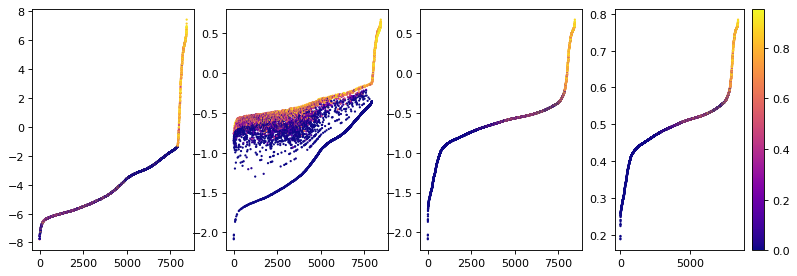

vibrant-sweep-1_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.9054946120203557
dice 0.6844278477746826
pp_sum 0.8905564558452039
sqrt_gt_sum 0.8212216632794349
log_gt_sum 0.6229817770992154
e_log_gt_sum 0.6405467160639774
inv_e_log_gt_sum -0.5557517125366734
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with gt_sum 0.75
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with pp_sum 0.57
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with sqrt_gt_sum 0.75
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with log_gt_sum 0.81
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with e_log_gt_sum 0.86
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with inv_e_log_gt_sum 0.38


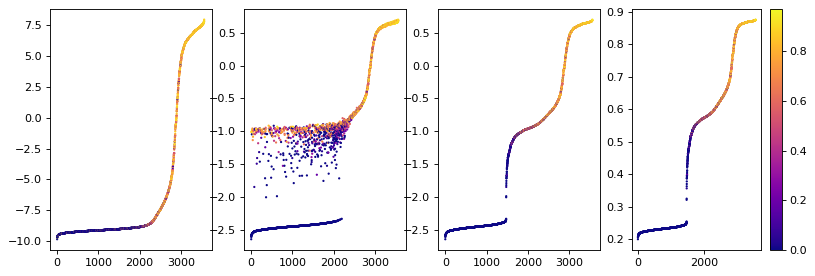

sandy-sweep-1_fold0_epx39/train_label_snapshot.pth has 7133 parameters.
disturbed_bool_vect nan
gt_sum 0.6450506528193903
dice 0.6656816965600373
pp_sum 0.788259826519787
sqrt_gt_sum 0.66483887570814
log_gt_sum 0.5636322099996578
e_log_gt_sum 0.5764050477281146
inv_e_log_gt_sum -0.5157992007878867
Corr coeff DP_weight/dice 0.67 vs. DP_reweight/dice with gt_sum 0.76
Corr coeff DP_weight/dice 0.67 vs. DP_reweight/dice with pp_sum 0.54
Corr coeff DP_weight/dice 0.67 vs. DP_reweight/dice with sqrt_gt_sum 0.76
Corr coeff DP_weight/dice 0.67 vs. DP_reweight/dice with log_gt_sum 0.81
Corr coeff DP_weight/dice 0.67 vs. DP_reweight/dice with e_log_gt_sum 0.86
Corr coeff DP_weight/dice 0.67 vs. DP_reweight/dice with inv_e_log_gt_sum 0.34


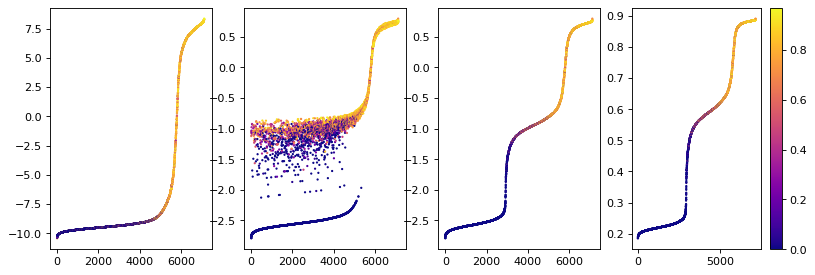

likely-water-1001_fold0_epx39/train_label_snapshot.pth has 7133 parameters.
disturbed_bool_vect nan
gt_sum -0.6737497213620125
dice -0.7508005264358919
pp_sum -0.5990761143888603
sqrt_gt_sum -0.8336621051818041
log_gt_sum -0.9166052911730375
e_log_gt_sum -0.916119742537371
inv_e_log_gt_sum 0.9125690838537011
Corr coeff DP_weight/dice -0.75 vs. DP_reweight/dice with gt_sum -0.62
Corr coeff DP_weight/dice -0.75 vs. DP_reweight/dice with pp_sum -0.49
Corr coeff DP_weight/dice -0.75 vs. DP_reweight/dice with sqrt_gt_sum -0.62
Corr coeff DP_weight/dice -0.75 vs. DP_reweight/dice with log_gt_sum -0.66
Corr coeff DP_weight/dice -0.75 vs. DP_reweight/dice with e_log_gt_sum -0.70
Corr coeff DP_weight/dice -0.75 vs. DP_reweight/dice with inv_e_log_gt_sum -0.79


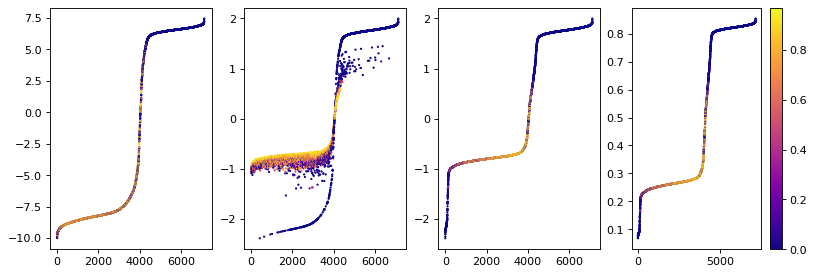

scarlet-flower-1005_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect -0.2884584929092048
gt_sum 0.7391387215956519
dice 0.6130901007274118
pp_sum 0.6297005927272542
sqrt_gt_sum 0.724058889163335
log_gt_sum 0.5746556655475452
e_log_gt_sum 0.5903539754847318
inv_e_log_gt_sum -0.5132124083566978
Corr coeff DP_weight/dice 0.61 vs. DP_reweight/dice with gt_sum 0.79
Corr coeff DP_weight/dice 0.61 vs. DP_reweight/dice with pp_sum 0.34
Corr coeff DP_weight/dice 0.61 vs. DP_reweight/dice with sqrt_gt_sum 0.79
Corr coeff DP_weight/dice 0.61 vs. DP_reweight/dice with log_gt_sum 0.83
Corr coeff DP_weight/dice 0.61 vs. DP_reweight/dice with e_log_gt_sum 0.82
Corr coeff DP_weight/dice 0.61 vs. DP_reweight/dice with inv_e_log_gt_sum 0.38


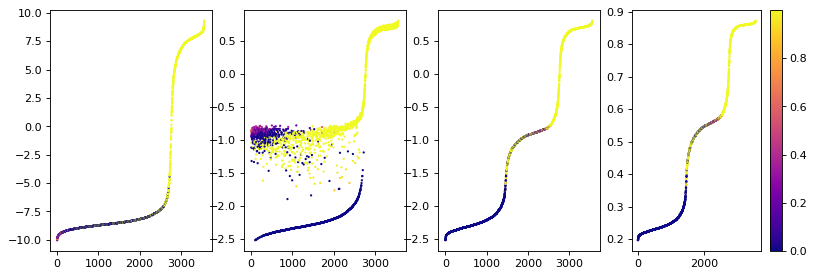

brisk-hill-1012_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect -0.24783867359707124
gt_sum 0.7541242189646297
dice 0.41674196138892544
pp_sum 0.7111057282984655
sqrt_gt_sum 0.6196658991732981
log_gt_sum 0.3963007130612373
e_log_gt_sum 0.41317515411664435
inv_e_log_gt_sum -0.3296280650337094
Corr coeff DP_weight/dice 0.42 vs. DP_reweight/dice with gt_sum 0.79
Corr coeff DP_weight/dice 0.42 vs. DP_reweight/dice with pp_sum 0.56
Corr coeff DP_weight/dice 0.42 vs. DP_reweight/dice with sqrt_gt_sum 0.79
Corr coeff DP_weight/dice 0.42 vs. DP_reweight/dice with log_gt_sum 0.81
Corr coeff DP_weight/dice 0.42 vs. DP_reweight/dice with e_log_gt_sum 0.80
Corr coeff DP_weight/dice 0.42 vs. DP_reweight/dice with inv_e_log_gt_sum -0.19


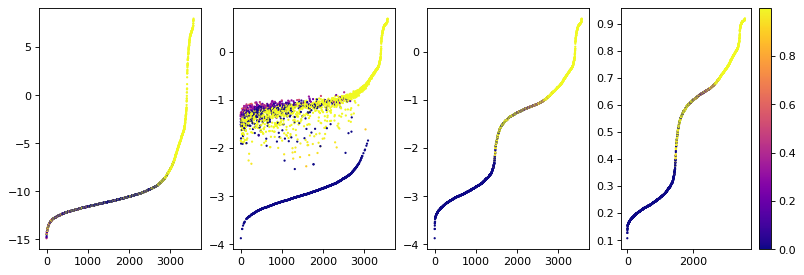

sleek-eon-1014_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.8722781215223433
dice 0.768568423606706
pp_sum 0.8562162370263064
sqrt_gt_sum 0.7838197242229253
log_gt_sum 0.623001793112801
e_log_gt_sum 0.6375119397332688
inv_e_log_gt_sum -0.5696579765732585
Corr coeff DP_weight/dice 0.77 vs. DP_reweight/dice with gt_sum 0.72
Corr coeff DP_weight/dice 0.77 vs. DP_reweight/dice with pp_sum 0.48
Corr coeff DP_weight/dice 0.77 vs. DP_reweight/dice with sqrt_gt_sum 0.72
Corr coeff DP_weight/dice 0.77 vs. DP_reweight/dice with log_gt_sum 0.79
Corr coeff DP_weight/dice 0.77 vs. DP_reweight/dice with e_log_gt_sum 0.86
Corr coeff DP_weight/dice 0.77 vs. DP_reweight/dice with inv_e_log_gt_sum 0.52


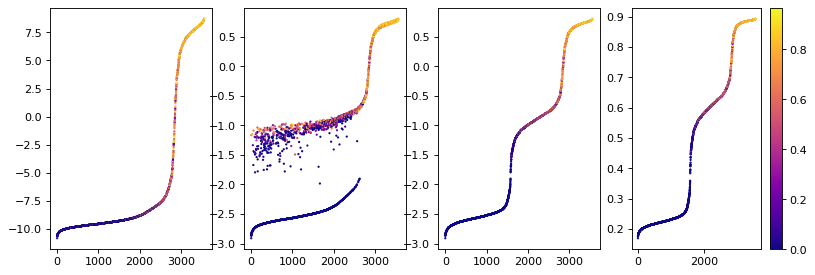

pretty-darkness-1015_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.895002460659153
dice 0.758062351566226
pp_sum 0.8927963780722189
sqrt_gt_sum 0.8068660408971708
log_gt_sum 0.6443046578162618
e_log_gt_sum 0.6589552086186431
inv_e_log_gt_sum -0.5902484211650674
Corr coeff DP_weight/dice 0.76 vs. DP_reweight/dice with gt_sum 0.72
Corr coeff DP_weight/dice 0.76 vs. DP_reweight/dice with pp_sum 0.50
Corr coeff DP_weight/dice 0.76 vs. DP_reweight/dice with sqrt_gt_sum 0.72
Corr coeff DP_weight/dice 0.76 vs. DP_reweight/dice with log_gt_sum 0.79
Corr coeff DP_weight/dice 0.76 vs. DP_reweight/dice with e_log_gt_sum 0.85
Corr coeff DP_weight/dice 0.76 vs. DP_reweight/dice with inv_e_log_gt_sum 0.51


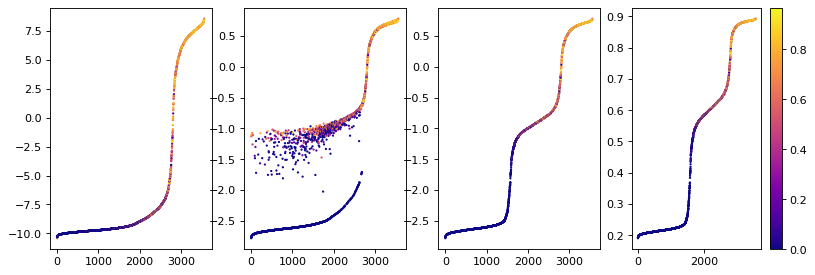

rose-bird-1016_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.6524641077946004
dice 0.6797385259107469
pp_sum 0.6903229854393174
sqrt_gt_sum 0.5892863492222705
log_gt_sum 0.46675624171069124
e_log_gt_sum 0.47765781660112605
inv_e_log_gt_sum -0.42593603295403437
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with gt_sum 0.42
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with pp_sum 0.44
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with sqrt_gt_sum 0.42
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with log_gt_sum 0.51
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with e_log_gt_sum 0.62
Corr coeff DP_weight/dice 0.68 vs. DP_reweight/dice with inv_e_log_gt_sum 0.65


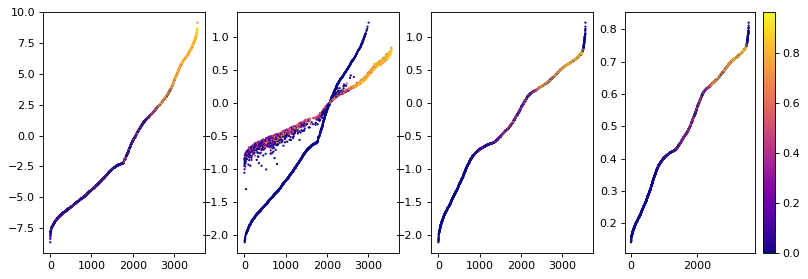

dummy-9te7cY9kUYjtcZ3i4a83i6_fold0_epx0/train_label_snapshot.pth has 33 parameters.
disturbed_bool_vect nan
gt_sum 0.7446811621043498
dice 0.8905127584044696
pp_sum -0.7851216411125077
sqrt_gt_sum 0.8518578981509448
log_gt_sum 0.9502939000737547
e_log_gt_sum 0.940883195764526
inv_e_log_gt_sum -0.9686391185668257
Corr coeff DP_weight/dice 0.89 vs. DP_reweight/dice with gt_sum 0.89
Corr coeff DP_weight/dice 0.89 vs. DP_reweight/dice with pp_sum 0.91
Corr coeff DP_weight/dice 0.89 vs. DP_reweight/dice with sqrt_gt_sum 0.89
Corr coeff DP_weight/dice 0.89 vs. DP_reweight/dice with log_gt_sum 0.88
Corr coeff DP_weight/dice 0.89 vs. DP_reweight/dice with e_log_gt_sum 0.86
Corr coeff DP_weight/dice 0.89 vs. DP_reweight/dice with inv_e_log_gt_sum 0.93


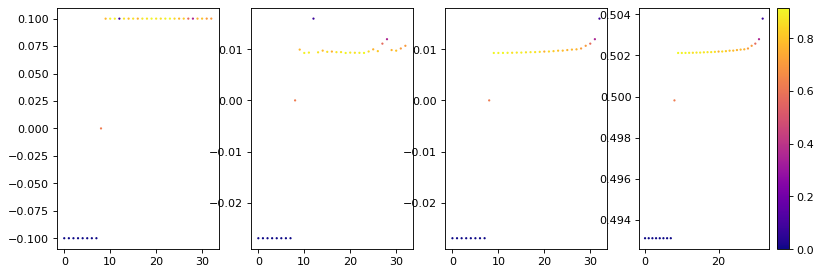

fearless-thunder-1017_fold0_epx39/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.8598061668479756
dice 0.8084356523408389
pp_sum 0.8778908986258479
sqrt_gt_sum 0.7930137233710853
log_gt_sum 0.6483456663421103
e_log_gt_sum 0.6622067259206503
inv_e_log_gt_sum -0.5975277088239819
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with gt_sum 0.71
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with pp_sum 0.76
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with sqrt_gt_sum 0.71
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with log_gt_sum 0.78
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with e_log_gt_sum 0.86
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with inv_e_log_gt_sum 0.62


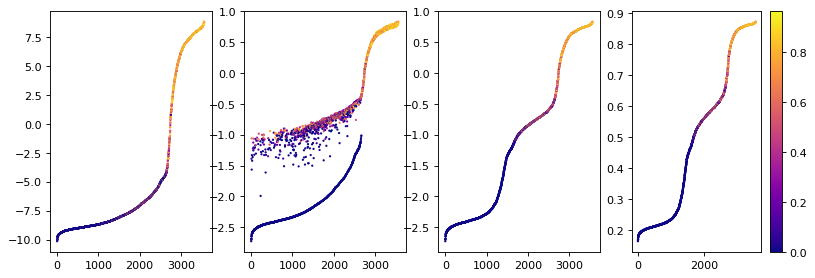

cerulean-thunder-1018_fold0_epx59/train_label_snapshot.pth has 3566 parameters.
disturbed_bool_vect nan
gt_sum 0.8278054469506166
dice 0.8095933224664398
pp_sum 0.8200475012664931
sqrt_gt_sum 0.7831021758690532
log_gt_sum 0.6618948166652153
e_log_gt_sum 0.6739964577386311
inv_e_log_gt_sum -0.6168721418098405
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with gt_sum 0.67
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with pp_sum 0.69
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with sqrt_gt_sum 0.67
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with log_gt_sum 0.75
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with e_log_gt_sum 0.83
Corr coeff DP_weight/dice 0.81 vs. DP_reweight/dice with inv_e_log_gt_sum 0.68


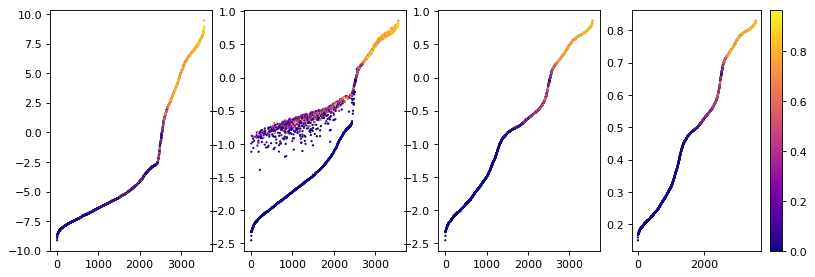

In [5]:
file_paths = [
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/crimson-oath-956_fold0_epx39/train_label_snapshot.pth',
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/_clean-morning-918_fold0_epx39/train_label_snapshot.pth'
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/clear-sweep-1_fold0_epx39/train_label_snapshot.pth'
]

file_paths = glob.glob('./data/output/**/*.pth')

for _path in file_paths:
    data = torch.load(_path)
    dp_mean_weight = data['data_parameters'].squeeze()
    disturb_flags = data['disturb_flags'] 
    d_ids = data['d_ids'] 
    dataset_idxs = data['dataset_idxs'] 
    _2d_labels = data['labels']
    _2d_modified_labels = data['modified_labels']
    _2d_predictions = data['train_predictions']
    print(f"{'/'.join(_path.split('/')[-2:])} has {len(dp_mean_weight)} parameters.")

    _2d_labels = _2d_labels.to_dense()
    _2d_modified_labels = _2d_modified_labels.to_dense()
    _2d_predictions = _2d_predictions.to_dense()

    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_predictions.sum((-2,-1)).squeeze(1).cpu()
    rgt_sum =  _2d_labels.sum((-2,-1)).cpu()
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(rgt_sum+gt_sum+1)

    all_elems = \
        dict(
            disturbed_bool_vect = torch.tensor(disturb_flags).float(),
            gt_sum=gt_sum, 
            dice=dice, 
            pp_sum=pp_sum,
            sqrt_gt_sum=np.sqrt(gt_sum),
            log_gt_sum=np.log(gt_sum+1)+1, # this seems to be right
            e_log_gt_sum=np.log(gt_sum+np.exp(1))+np.exp(1),
            inv_e_log_gt_sum=1/(np.log(gt_sum+np.exp(1))+np.exp(1)),
        )
    
    for name, metric in all_elems.items():
        print(name, np.corrcoef(dp_mean_weight.cpu().detach(), metric.detach())[0,1])
    for name, metric in all_elems.items():
        if name in ['dice', 'disturbed_bool_vect']: continue
        
        print(f"Corr coeff DP_weight/dice {np.corrcoef(dp_mean_weight.detach(), dice.detach())[0,1]:.2f} vs. DP_reweight/dice with {name} {np.corrcoef((dp_mean_weight/(metric+1e-6)).cpu().detach(), dice.detach())[0,1]:.2f}")
    reweighted = dp_mean_weight/(all_elems['e_log_gt_sum'])

    # sel_idxs = reweighted<100
    sel_idxs = range(len(reweighted))
    srtd_reweighted = reweighted[sel_idxs]
    srtd_dice_reweighted = dice[sel_idxs]

    srtd = sorted(zip(srtd_reweighted, srtd_dice_reweighted))
    srtd_reweighted, srtd_dice_reweighted = zip(*srtd)
    srtd_reweighted, srtd_dice_reweighted = torch.stack(srtd_reweighted), torch.stack(srtd_dice_reweighted)

    # Show weights and weights with compensation
    fig, axs = plt.subplots(1,4, figsize=(12, 4), dpi=80)
    sc1 = axs[0].scatter(
        range(len(dp_mean_weight)), 
        dp_mean_weight.cpu().detach(), c=dice,s=1, cmap='plasma');
    sc2 = axs[1].scatter(
        range(len(dp_mean_weight)), 
        reweighted.cpu().detach(), 
        s=1,c=dice, cmap='plasma')
    sc3 = axs[2].scatter(
        range(len(srtd_reweighted)), 
        srtd_reweighted.detach().numpy(), 
        s=1,c=srtd_dice_reweighted, cmap='plasma');
    sc4 = axs[3].scatter(
        range(len(srtd_reweighted)), 
        torch.sigmoid(srtd_reweighted-srtd_reweighted.mean()).detach().numpy(), 
        s=1,c=srtd_dice_reweighted, cmap='plasma');
    plt.colorbar(sc4)
    plt.show()

In [4]:
print(gt_sum[-20:])

print(dp_mean_weight[-20:])
dp_mean_weight[-20:]/(1+np.exp(1))
# (np.log(gt_sum+np.exp(1))+np.exp(1))

print(len(dp_mean_weight))
print(len(gt_sum))

print(reweighted[-20:])


tensor([3232, 3872, 2904, 2872, 3916, 4052, 2900, 2856, 3532, 2584, 4084, 2652,
        3444, 3036, 3836, 2372, 3328, 3640, 3100, 2852])
tensor([8.5572, 8.5628, 8.5724, 8.5731, 8.5753, 8.5784, 8.5841, 8.5941, 8.5974,
        8.6019, 8.6096, 8.6139, 8.6359, 8.7125, 8.7363, 8.7366, 8.7645, 8.7683,
        8.7842, 8.8208], grad_fn=<SliceBackward>)
3566
3566
tensor([0.7923, 0.7798, 0.8017, 0.8026, 0.7802, 0.7780, 0.8029, 0.8050, 0.7896,
        0.8133, 0.7803, 0.8124, 0.7949, 0.8114, 0.7963, 0.8328, 0.8093, 0.8031,
        0.8165, 0.8263], grad_fn=<SliceBackward>)


In [ ]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label
selected_weight = reweighted
data = zip(selected_weight, d_ids, _2d_labels, _2d_modified_labels, _2d_predictions)


samples_sorted = sorted(data, key=lambda tpl: tpl[0])
(dp_weightss, d_idss, _2d_lbl, _2d_ml, _2d_p) = zip(*samples_sorted)

overlay_text_list = [f"id:{d_id} gwd:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_idss, dp_weightss)]

visualize_seg(in_type="batch_2D",
    img=interpolate_sample(b_label=torch.stack(_2d_lbl), scale_factor=.5, yield_2d=True)[1].unsqueeze(1),
    seg=interpolate_sample(b_label=4*torch.stack(_2d_p).squeeze(1), scale_factor=.5, yield_2d=True)[1],
    ground_truth=interpolate_sample(b_label=torch.stack(_2d_ml), scale_factor=.5, yield_2d=True)[1],
    crop_to_non_zero_seg=False,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=70,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    file_path="out_reweight.png",
)

In [ ]:
torch.save(
    {
        'reweighted_weigths': sg_reweighted,
        'd_ids': d_ids 
    }, 
    'fixed_weights.pth'
)


In [ ]:
correction = \
    [
        1.0,
        1/(1+gt_sum).numpy(), 
        1/(1+np.sqrt(gt_sum)).numpy(),
        1/np.log(gt_sum+gt_sum.max().sqrt()).numpy(),
    ]

for crr in correction:
    print(np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy()*crr, dice)[0,1])


In [ ]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

for pth in glob.glob('./data/output/**/*.pth'):
    print(pth)
    data = torch.load(pth)
    dp_mean_weight, *_, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels = data
    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_labels.sum((-2,-1))
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(pp_sum+gt_sum)
    all_elems = dict(
            gt_sum=get_corr_coeff(gt_sum),
            intersect=get_corr_coeff(intersect),
            pp_sum=get_corr_coeff(pp_sum),
            sqrt=get_corr_coeff(np.sqrt(gt_sum)),
            log=get_corr_coeff(np.log(gt_sum+gt_sum.max().sqrt())), # this seems to be right
            dice=get_corr_coeff(dice)
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)
